In [1]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense,Normalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import random as rd

2024-05-05 16:27:04.900582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds_train=pd.read_csv("../train_hora.csv")
ds_train["date"]=pd.to_datetime(ds_train["date"],format="%Y-%m-%d %H:%M:%S")
ds_train=ds_train.set_index("date")
ds_test=pd.read_csv("../test_hora.csv")
ds_test["date"]=pd.to_datetime(ds_test["date"],format="%Y-%m-%d %H:%M:%S")
ds_test=ds_test.set_index("date")

In [3]:
t_media=pd.read_csv("../temperaturas/DMC_330020_Quinta_Normal_Santiago_media.csv",sep=";")
t_media["date"]=pd.to_datetime(t_media["date"],format="%Y-%m-%d %H:%M:%S")
t_media=t_media.set_index("date")
fin= datetime.strptime("2023-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
t_media_fin=t_media.loc[fin]
t_media=t_media.query("date.dt.year>2017 and date.dt.year<2023")
t_media.loc[fin]=t_media_fin
t_minima=pd.read_csv("../temperaturas/DMC_330020_Quinta_Normal_Santiago_minima.csv",sep=";")
t_minima["date"]=pd.to_datetime(t_minima["date"],format="%Y-%m-%d %H:%M:%S")
t_minima=t_minima.set_index("date")
t_minima_fin=t_minima.loc[fin]
t_minima=t_minima.query("date.dt.year>2017 and date.dt.year<2023")
t_minima.loc[fin]=t_minima_fin
t_maxima=pd.read_csv("../temperaturas/DMC_330020_Quinta_Normal_Santiago_maxima.csv",sep=";")
t_maxima["date"]=pd.to_datetime(t_maxima["date"],format="%Y-%m-%d %H:%M:%S")
t_maxima=t_maxima.set_index("date")
t_maxima_fin=t_maxima.loc[fin]
t_maxima=t_maxima.query("date.dt.year>2017 and date.dt.year<2023")
t_maxima.loc[fin]=t_maxima_fin

In [4]:
t_media_hora=t_media.resample("1h").ffill()
t_maxima_hora=t_maxima.resample("1h").ffill()
t_minima_hora=t_minima.resample("1h").ffill()
t_media_train=t_media_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_media_test=t_media_hora.query("date.dt.year==2022")
t_minima_train=t_minima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_minima_test=t_minima_hora.query("date.dt.year==2022")
t_maxima_train=t_maxima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_maxima_test=t_maxima_hora.query("date.dt.year==2022")

In [5]:
ds_train=ds_train.join(t_minima_train["t_minima"])
ds_train=ds_train.join(t_media_train["t_media"])
ds_train=ds_train.join(t_maxima_train["t_maxima"])
ds_train["w"]=ds_train.index.dayofweek
ds_train["m"]=ds_train.index.month
ds_train["h"]=ds_train.index.hour
print(pearsonr(ds_train["consumption"],ds_train["t_media"]))
print(pearsonr(ds_train["consumption"],ds_train["t_minima"]))
print(pearsonr(ds_train["consumption"],ds_train["t_maxima"]))
print(pearsonr(ds_train["consumption"],ds_train["w"]))
print(pearsonr(ds_train["consumption"],ds_train["m"]))
print(pearsonr(ds_train["consumption"],ds_train["h"]))

PearsonRResult(statistic=-0.48083788888868956, pvalue=0.0)
PearsonRResult(statistic=-0.4364928885507775, pvalue=0.0)
PearsonRResult(statistic=-0.44762732525762555, pvalue=0.0)
PearsonRResult(statistic=-0.16901818798725682, pvalue=5.429055703234984e-223)
PearsonRResult(statistic=0.1265849293928329, pvalue=3.465196248245333e-125)
PearsonRResult(statistic=0.5246818887301639, pvalue=0.0)


In [6]:
ds_test=ds_test.join(t_minima_test["t_minima"])
ds_test=ds_test.join(t_media_test["t_media"])
ds_test=ds_test.join(t_maxima_test["t_maxima"])
ds_test["w"]=ds_test.index.dayofweek
ds_test["m"]=ds_test.index.month
ds_test["h"]=ds_test.index.hour
print(pearsonr(ds_test["consumption"],ds_test["t_media"]))
print(pearsonr(ds_test["consumption"],ds_test["t_minima"]))
print(pearsonr(ds_test["consumption"],ds_test["t_maxima"]))
print(pearsonr(ds_test["consumption"],ds_test["w"]))
print(pearsonr(ds_test["consumption"],ds_test["m"]))
print(pearsonr(ds_test["consumption"],ds_test["h"]))

PearsonRResult(statistic=-0.5694986997612126, pvalue=0.0)
PearsonRResult(statistic=-0.5342029994894597, pvalue=0.0)
PearsonRResult(statistic=-0.5223074129267719, pvalue=0.0)
PearsonRResult(statistic=-0.1262871138294452, pvalue=1.784645742428329e-32)
PearsonRResult(statistic=0.03290210819630109, pvalue=0.002070958740669617)
PearsonRResult(statistic=0.47756823164543905, pvalue=0.0)


In [7]:
y_train=ds_train[["consumption","t_media","w","h"]].to_numpy()
y_test=ds_test[["consumption","t_media","w","h"]].to_numpy()
print(len(y_train)+len(y_test))

43824


In [8]:
yw_train=[]
ytw_train=[]
window=336
for i in range(0,len(y_train)):
    if i+window < len(y_train):
        row=[]
        for j in range(168):
            row.append(y_train[i+j])
        yw_train.append(row)
        row=[]
        for j in range(168):
            row.append(y_train[i+48+j][0])
        ytw_train.append(row)
    else:
        break
yw_train=np.asarray(yw_train)
ytw_train=np.asarray(ytw_train)
print(yw_train.shape,ytw_train.shape)

(34728, 168, 4) (34728, 168)


In [9]:
yw_test=[]
ytw_test=[]
window=336
for i in range(0,len(y_test)):
    if i+window < len(y_test):
        row=[]
        for j in range(168):
            row.append(y_test[i+j])
        yw_test.append(row)
        row=[]
        for j in range(168):
            row.append(y_test[i+48+j][0])
        ytw_test.append(row)
    else:
        break
yw_test=np.asarray(yw_test)
ytw_test=np.asarray(ytw_test)
print(yw_test.shape,ytw_test.shape)

(8424, 168, 4) (8424, 168)


In [11]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
initializer=tf.keras.initializers.GlorotUniform(seed=seed)
model = Sequential()
model.add(Input(name="serie",shape=(168,4)))
model.add(LSTM(512,kernel_initializer=initializer))
model.add(Dense(256,kernel_initializer=initializer))
model.add(Dense(168, kernel_initializer=initializer,activation='linear'))
tag="rnn_htw_512_256"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="min",
    restore_best_weights=True
)
optimizer=Adam(learning_rate=1e-5)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw_train, ytw_train, validation_data=(yw_test,ytw_test),
                batch_size=256, epochs=96,shuffle=True,verbose=1,
                callbacks=[tensorboard_callback,earlystopping_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 18.5875 - mae: 19.0814 - mse: 598.1407 - val_loss: 10.3431 - val_mae: 10.8331 - val_mse: 181.9018
Epoch 2/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - loss: 8.9717 - mae: 9.4621 - mse: 131.0487 - val_loss: 9.0835 - val_mae: 9.5727 - val_mse: 136.2156
Epoch 3/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - loss: 7.9177 - mae: 8.4063 - mse: 106.6041 - val_loss: 7.3491 - val_mae: 7.8357 - val_mse: 97.6899
Epoch 4/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - loss: 6.3049 - mae: 6.7891 - mse: 75.6774 - val_loss: 5.4550 - val_mae: 5.9368 - val_mse: 60.4508
Epoch 5/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 5.1145 - mae: 5.5942 - mse: 55.7149 - val_loss: 5.1112 - val_mae: 5.5905 - val_mse: 55.7387
Epoch 6/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 4.6161 - mae: 5.0925 - mse: 48.6514 - val_loss: 4.4399 - val_mae: 4.9159 - val_mse: 44.8232
Epoch 7/96
136/136 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - loss: 4.0103 - mae

In [12]:
ultimo=yw_test[0].reshape(1,168,4)
ultimo.shape

(1, 168, 4)

31.84599220386905 1.302321138629368 0.04089434960268394 0.04620869874363813


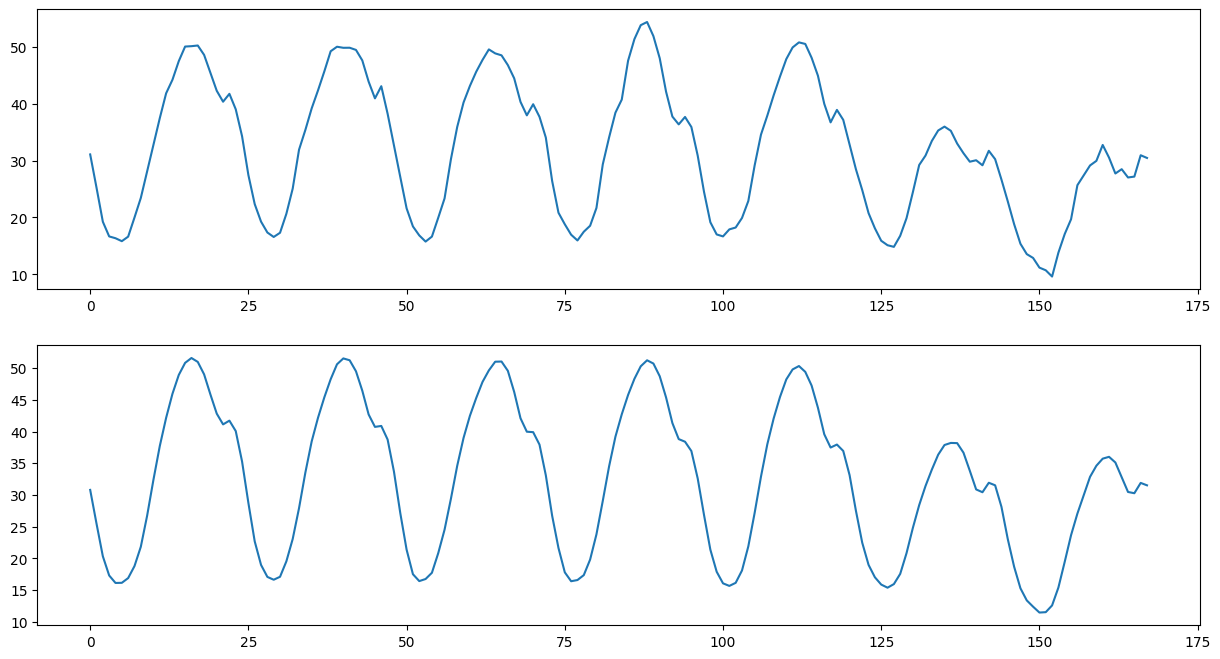

In [13]:
forecast=model.predict(ultimo,verbose=0)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
real=ytw_test[0].tolist()
pred=forecast[0].tolist()
axes[0].plot(real);
axes[1].plot(pred);
media=np.mean(real)
error=mean_absolute_error(real,pred)
error2=mean_absolute_percentage_error(real,pred)
print(media,error,error/media,error2)